In [18]:
"""
- Normal
    - Tension_Normal.csv
    - NTRNL_Normal # subfolder
        - 05-31 23_35_19.txt
        ...
    - XTRNL_Normal # subfolder
        - 20230531_233519.csv
        ...
- CoreExposed
    - Tension_CoreExposed.csv
    - NTRNL_CoreExposed # subfolder
        - 06-01 16_04_36.txt
        ...
    - XTRNL_CoreExposed # subfolder
        - 20230601_160436.csv
        ...
- CoreSevered
    - Tension_CoreSevered.csv
    - NTRNL_CoreSevered # subfolder
        - 06-01 01_49_17.txt
        ...
    - XTRNL_CoreSevered # subfolder
        - 20230601_014917.csv
        ...
- SideDamaged
    - Tension_SideDamaged.csv
    - NTRNL_SideDamaged # subfolder
        - 05-31 20_54_14.txt
        ...
    - XTRNL_SideDamaged # subfolder
        - 20230531_205414.csv
        ...
"""

'\n- Normal\n    - Tension_Normal.csv\n    - NTRNL_Normal # subfolder\n        - 05-31 23_35_19.txt\n        ...\n    - XTRNL_Normal # subfolder\n        - 20230531_233519.csv\n        ...\n- CoreExposed\n    - Tension_CoreExposed.csv\n    - NTRNL_CoreExposed # subfolder\n        - 06-01 16_04_36.txt\n        ...\n    - XTRNL_CoreExposed # subfolder\n        - 20230601_160436.csv\n        ...\n- CoreSevered\n    - Tension_CoreSevered.csv\n    - NTRNL_CoreSevered # subfolder\n        - 06-01 01_49_17.txt\n        ...\n    - XTRNL_CoreSevered # subfolder\n        - 20230601_014917.csv\n        ...\n- SideDamaged\n    - Tension_SideDamaged.csv\n    - NTRNL_SideDamaged # subfolder\n        - 05-31 20_54_14.txt\n        ...\n    - XTRNL_SideDamaged # subfolder\n        - 20230531_205414.csv\n        ...\n'

In [1]:
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
from datetime import timedelta
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report

### 수집한 신호로부터 변수로 사용할 대푯값 추출 및 표준화
#### 벨트의 Tension, 소리의 Mean, Variance, Skew, Kurtosis, 각 변수들의 RMS(제곱평균제곱근)를 독립 변수로 설정.

In [2]:
Directory_Path = 'C:/Users/99kit/Desktop/CapstoneDesign2/' # 폴더 'CapstoneDesign2'
Root_Directory = ['Normal', 'CoreExposed', 'CoreSevered', 'SideDamaged'] # 메인 폴더명(4개) 리스트

for directory in Root_Directory: # 메인 폴더명 리스트 이용하여 반복문 실행
    os.chdir(Directory_Path + directory) # e.g. C:/Users/99kit/Desktop/CapstoneDesign2/Normal
    
    # Tension
    Tension = pd.read_csv("Tension_" + directory + ".csv", encoding='cp949') # 변수 'Tension' 생성. csv 파일 하나를 다룸.
    Tension['Unnamed: 0'] = pd.to_datetime(Tension['Unnamed: 0'], format='[%Y/%m/%d] %H:%M:%S') # 이름 없는 열의 데이터를 날짜와 시간 형식으로 변환
    
    Tension['Formatted_Time'] = Tension['Unnamed: 0'].dt.strftime('NTRNL_' + directory + '\\%m-%d %H_%M_%S.txt') # 열 'Formatted_Time' 생성. 각 행에 NTRNL_메인 폴더명\파일 수집 월-일 시_분_초.txt 형식의 문자열 저장
    
    # XTRNL Sound Sensor
    list_max_values = [] # 빈 리스트 'list_max_values' 생성. 최댓값을 할당할 리스트
    for csv_file in glob.glob('*/*.csv'): # 현재 directory의 하위 폴더에서 확장자 '.csv'를 가진 파일의 위치와 이름(하위 폴더\\파일명)을 담은 리스트를 생성
        df = pd.read_csv(csv_file) # 변수 'df' 생성함. df = 하위 폴더\\파일명.csv(n번째)
        list_max_values.append(df['External Sound'].max()) # df의 열 'External Sound'에서 최댓값을 찾아 리스트 'list_max_values'에 추가
    Tension['Max_XTRNL_Sound'] = list_max_values
            
    # NTRNL Sound Sensor의 평균, 분산
    dictionary_mean = {} # 빈 사전 생성
    dictionary_var = {} # 빈 사전 생성
    dictionary_skew = {} # 첨도
    dictionary_kurt = {}
    for txt_file in glob.glob('*/*.txt'): # 현재 directiory의 하위 폴더에서 확장자 '.txt'를 가진 파일의 위치와 이름을 담은 리스트를 생성
        with open(txt_file, 'r') as file: # file이란 객체로 직전에 만든 리스트의 n번째 변수 읽기
            data = [] # 빈 리스트 'data' 생성
            for line in file: # file을 한 줄씩 읽는 반복문 실행
                values = line.strip().split(',') # ','를 기준으로 문자열 나누기. 나눈 문자열들을 변수 values에 저장
                if len(values) == 3: # values에 저장된 문자열 자료형의 개수가 3개인 경우 조건문 실행
                    data.append(int(values[0])) # values의 첫 번째 문자열 자료형(sound)을 정수형으로 변환 후 리스트 'data'에 추가
        dictionary_mean[txt_file] = np.mean(data)
        dictionary_var[txt_file] = np.var(data)
        dictionary_skew[txt_file] = scipy.stats.skew(data)
        dictionary_kurt[txt_file] = scipy.stats.kurtosis(data)    
    Tension['Mean_Int_Sound'] = Tension['Formatted_Time'].map(dictionary_mean)
    Tension['Mean_Int_Sound'].interpolate(inplace = True) # 결측치 선형 보간
    Tension['Var_Int_Sound'] = Tension['Formatted_Time'].map(dictionary_var)
    Tension['Var_Int_Sound'].interpolate(inplace = True) # 결측치 선형 보간
    Tension['Skew_Int_Sound'] = Tension['Formatted_Time'].map(dictionary_skew)
    Tension['Skew_Int_Sound'].interpolate(inplace = True) # 결측치 선형 보간    
    Tension['Kurt_Int_Sound'] = Tension['Formatted_Time'].map(dictionary_kurt)
    Tension['Kurt_Int_Sound'].interpolate(inplace = True) # 결측치 선형 보간 
    
    Tension = Tension.dropna().reset_index(drop=True) # 결측치가 있는 행 삭제, 인덱스 reset

    # Int. Sound의 최댓값을 나타내는 열의 이상치 인데스 파악: A
    Q1 = Tension['Max_XTRNL_Sound'].quantile(0.25)
    Q3 = Tension['Max_XTRNL_Sound'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_max_xtrnl_sound = Tension[(Tension['Max_XTRNL_Sound'] < lower_bound) | (Tension['Max_XTRNL_Sound'] > upper_bound)]
    # Int. Sound의 평균값을 나타내는 열의 이상치 인덱스 파악: B
    Q1_mean = Tension['Mean_Int_Sound'].quantile(0.25)
    Q3_mean = Tension['Mean_Int_Sound'].quantile(0.75)
    IQR_mean = Q3_mean - Q1_mean
    lower_bound_mean = Q1_mean - 1.5 * IQR_mean
    upper_bound_mean = Q3_mean + 1.5 * IQR_mean
    outliers_mean_ntrnl_sound = Tension[(Tension['Mean_Int_Sound'] < lower_bound_mean) | (Tension['Mean_Int_Sound'] > upper_bound_mean)]
    # A와 B의 교집합 파악 후 Int. Sound 열의 해당 인덱스에 선형 보간 수행
    common_indices = outliers_max_xtrnl_sound.index.intersection(outliers_mean_ntrnl_sound.index)
    Tension.loc[common_indices, 'Mean_Int_Sound'] = np.nan
    Tension['Mean_Int_Sound'].interpolate(inplace=True)
    
    Tension = Tension.drop(['Formatted_Time', 'Max_XTRNL_Sound'], axis = 1) # 필요 없는 열을 제거합니다.
    Tension['Type'] = directory
    
    Tension.loc[Tension['Type'] != 'Normal', 'AD'] = 'Abnormal'
    Tension.loc[Tension['Type'] == 'Normal', 'AD'] = 'Normal'
    
    if directory == 'Normal':
        df_Normal = Tension
    elif directory == 'CoreExposed':
        df_CoreExposed = Tension
    elif directory == 'CoreSevered':
        df_CoreSevered = Tension
    elif directory == 'SideDamaged':
        df_SideDamaged = Tension

# 하나의 데이터프레임으로 결합하고 열 이름을 변경합니다.
tb_data = pd.concat([df_Normal, df_CoreExposed, df_CoreSevered, df_SideDamaged], ignore_index = True)
tb_data = tb_data.rename(columns = {'벨트처짐':'Tension'})

independent_variables = ['Tension', 'Mean_Int_Sound', 'Var_Int_Sound', 'Skew_Int_Sound', 'Kurt_Int_Sound'] # 변수로 사용할 열을 지정합니다.###################################

# 데이터를 표준화합니다.
data_standardized = StandardScaler().fit_transform(tb_data[independent_variables])
tb_data_standardized = pd.DataFrame(data_standardized, columns=independent_variables)
tb_data[independent_variables] = tb_data_standardized

tb_data['RMS'] = np.sqrt((tb_data[independent_variables] ** 2).mean(axis=1)) # 독립 변수의 RMS 값을 구하여 새로운 열에 추가합니다.
tb_data['RMS'] = StandardScaler().fit_transform(tb_data[['RMS']]) # RMS 표준화
tb_data # 원본 데이터 프레임의 모든 독립 변수를 표준화하고 두 개의 레이블 정보를 부여함.

,Unnamed: 0,Tension,Mean_Int_Sound,Var_Int_Sound,Skew_Int_Sound,Kurt_Int_Sound,Type,AD,RMS
0,2023-05-31 23:35:19,-0.216452,-1.780290,0.235485,-0.209677,0.005047,Normal,Normal,-0.108221
1,2023-05-31 23:35:20,-0.204667,-0.470556,0.059753,0.655876,-0.858885,Normal,Normal,-0.669529
2,2023-05-31 23:35:21,-0.216452,-1.040747,0.163329,0.333842,-0.392346,Normal,Normal,-0.674304
3,2023-05-31 23:35:22,-0.240023,-1.600883,0.503912,-0.609384,-0.731790,Normal,Normal,0.003142
4,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,Normal,0.164931
...,...,...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,Abnormal,1.072568
14251,2023-05-31 21:53:56,-0.240023,-0.831468,-0.717530,0.131856,0.607366,SideDamaged,Abnormal,-0.591385
14252,2023-05-31 21:53:57,0.007473,-0.539040,0.135900,0.228446,-0.148179,SideDamaged,Abnormal,-1.190876
14253,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,Abnormal,0.356937


### Anomaly Detection을 위한 Threshold 설정에 앞서 Normal 데이터에 대해 PCA 적용
#### 새로운 Feature 6개 추출. 각 Feature의 누적 설명력 계산. 3차원 시각화.
#### 3개의 주성분으로 전체 Normal 데이터의 약 89% 설명 가능.

주성분의 누적 설명력: [0.4384479  0.74274843 0.89333206 0.97010447 0.99907441 1.        ]


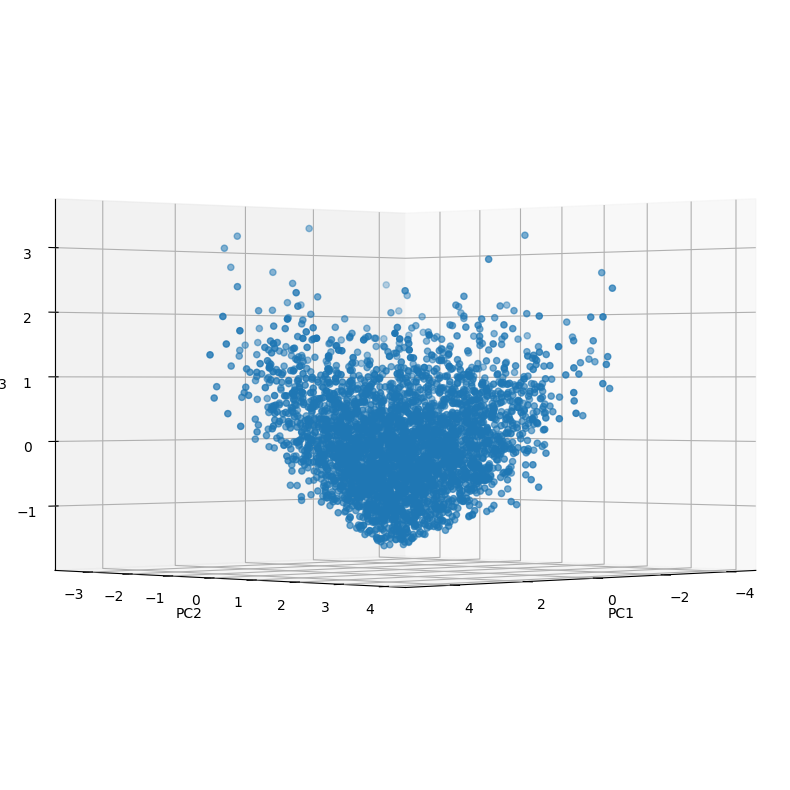

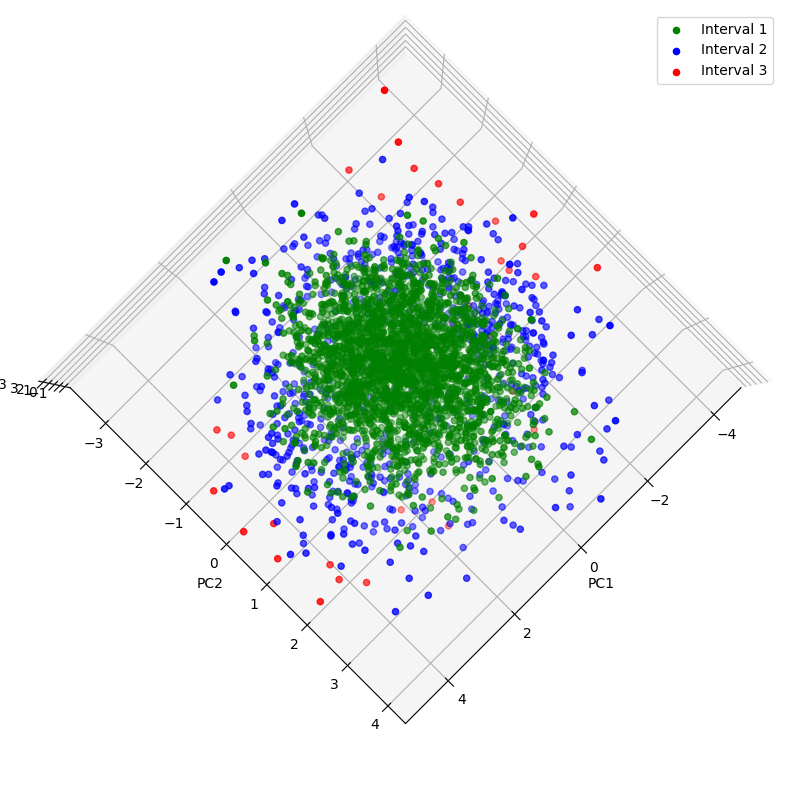

In [3]:
type_normal = tb_data[tb_data['Type'] == 'Normal']

independent_variables = ['Tension', 'Mean_Int_Sound', 'Var_Int_Sound', 'Skew_Int_Sound', 'Kurt_Int_Sound', 'RMS']
dependent_variables = ['Type', 'AD']

# Normal 데이터에만 PCA 적용
pca = PCA()
pca_normal = pca.fit_transform(type_normal[independent_variables])
pca_normal_cols = [f'PC{i+1}' for i in range(pca_normal.shape[1])]
pca_normal_df = pd.concat([pd.DataFrame(data = pca_normal, columns = pca_normal_cols), type_normal[dependent_variables]], axis = 1)
explained_var_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
print(f'주성분의 누적 설명력: {explained_var_ratio_cumsum}')

# pca_normal_df

# PCA 3d 시각화
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
pc1 = pca_normal_df['PC1']
pc2 = pca_normal_df['PC2']
pc3 = pca_normal_df['PC3']
ax.scatter(pc1, pc2, pc3, marker = 'o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
azimuth_angle = 45
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
# plt.legend()
plt.show()

# 약 8%의 설명력을 가진 4번째 주성분에 대한 정보를 3차원에 나타내기 위한 시각화
pca_normal_df['PC4_interval'] = pd.cut(pca_normal_df['PC4'], bins=3, labels=['Interval 1', 'Interval 2', 'Interval 3']) # 간격이 동일한 3구간으로 나눔
interval_colors = {'Interval 1': 'green', 'Interval 2': 'blue', 'Interval 3': 'red'}
pca_normal_df['Color'] = pca_normal_df['PC4_interval'].map(interval_colors)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for interval, color in interval_colors.items():
    subset = pca_normal_df[pca_normal_df['PC4_interval'] == interval]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], marker='o', c=color, label=interval)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
azimuth_angle = 45
elevation_angle = 89
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
plt.legend()
plt.show()
# print(len(pca_normal_df[pca_normal_df['PC4_interval'] == 'Interval 1'])) # 각 범주에 포함된 데이터 개수 확인
# print(len(pca_normal_df[pca_normal_df['PC4_interval'] == 'Interval 2']))
# print(len(pca_normal_df[pca_normal_df['PC4_interval'] == 'Interval 3']))

### Normal 데이터의 각 주성분의 평균 및 분산을 이용해 Mahalanobis Distance 계산
#### Normal 데이터의 평균과 각 데이터 포인트 사이의 거리 정보 추가.
#### Bootstrap 통해 95분위수를 구하고 그 평균을 Threshold로 정할 것.

In [4]:
pca_mean = pca_normal_df[pca_normal_cols].mean()
pca_cov = pca_normal_df[pca_normal_cols].cov()

def mahalanobis_distance(row):
    x = row[pca_normal_cols]
    return distance.mahalanobis(x, pca_mean, pca_cov)

pca_normal_df['Mahalanobis_Distance'] = pca_normal_df.apply(mahalanobis_distance, axis=1)

pca_normal_df

,PC1,PC2,PC3,PC4,PC5,PC6,Type,AD,PC4_interval,Color,Mahalanobis_Distance
0,0.186779,-0.799464,0.763208,-0.569065,-0.492598,0.034183,Normal,Normal,Interval 1,green,1.108523
1,0.451214,-1.156359,-0.788508,0.087842,0.228638,0.049017,Normal,Normal,Interval 1,green,1.485977
2,0.265783,-1.057490,-0.293279,-0.335068,-0.205934,0.033099,Normal,Normal,Interval 1,green,1.212477
3,0.990362,-0.554417,0.739521,-0.550608,-0.156982,0.010553,Normal,Normal,Interval 1,green,1.532953
4,1.837525,-1.097863,-0.459265,0.957511,-0.105529,0.008834,Normal,Normal,Interval 2,blue,2.696920
...,...,...,...,...,...,...,...,...,...,...,...
3576,-2.037413,0.875779,0.757414,0.253705,-0.489197,0.024102,Normal,Normal,Interval 1,green,2.833196
3577,-0.828063,-0.036906,1.136086,-0.685227,0.168893,-0.101718,Normal,Normal,Interval 1,green,1.409171
3578,-0.348479,-1.133006,-0.392441,-0.135481,-0.411165,-0.071012,Normal,Normal,Interval 1,green,1.328900
3579,-0.793719,0.149167,-0.078343,-0.504576,0.168906,-0.069691,Normal,Normal,Interval 1,green,1.065447


### Bootstrap을 통해 Anomaly Detection을 위한 Threshold 결정
#### 95%의 신뢰구간에서 Threshold는 약 3.69로 계산됨.
#### 14255개의 전체 데이터 중 Normal 데이터의 평균과의 거리가 약 3.69 이상인 데이터는 Anomaly로 규정할 것.

Anomaly_threshold: 3.6921007056793207


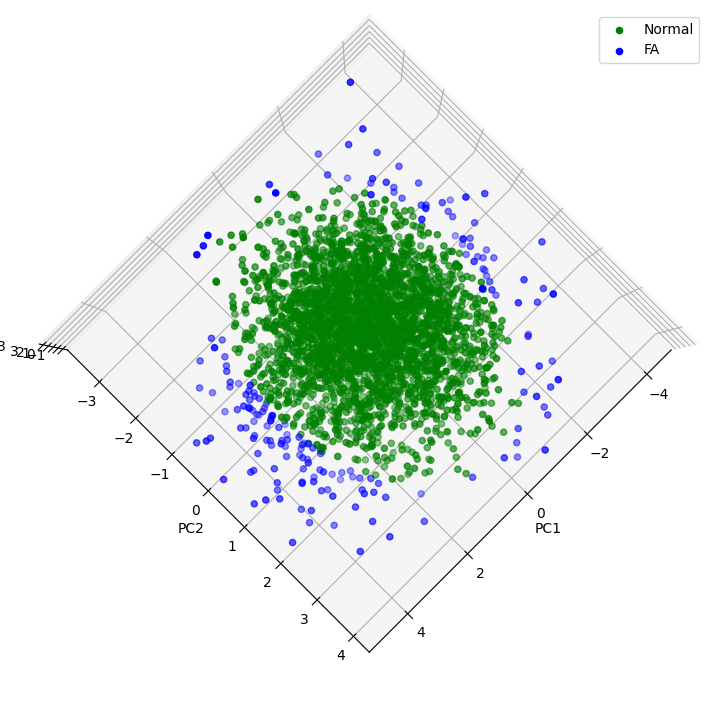

In [5]:
bootstrap_iterations = 100
confidence_level = 95

list_bootstrap_statistics = []
for _ in range(bootstrap_iterations):
    bootstrap_sample = np.random.choice(pca_normal_df['Mahalanobis_Distance'], size = len(pca_normal_df), replace = True)
    list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))
Anomaly_threshold = np.mean(list_bootstrap_statistics)
print(f'Anomaly_threshold: {Anomaly_threshold}')

# AD = Normal + FA + Abnormal
pca_normal_df.loc[pca_normal_df['Mahalanobis_Distance'] >= Anomaly_threshold, 'AD'] = 'FA' ###### 기억하자

# pca_normal_df

# 시각화
ad_type2color = {'Normal': 'green', 'FA': 'blue'}#, 'Abnormal': 'red'}

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
pc1 = pca_normal_df['PC1']
pc2 = pca_normal_df['PC2']
pc3 = pca_normal_df['PC3']
type = pca_normal_df['AD']
for t in ad_type2color:
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], c = ad_type2color[t], label = t, marker = 'o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
azimuth_angle = 45
elevation_angle = 89
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
ax.legend()
plt.show()

### Normal 데이터로 학습시킨 PCA 모델에 맞게 Abnormal 데이터 Transform 후 Anomaly Detection
#### 약 850개의 이상 감지. Threshold를 넘지 않는 Normal과 MD는 분류할 필요 없음.
#### 1종 오류의 비율을 줄이기 위해 FA 및 Abnormal 데이터를 활용하여 False Alarm Classification 모델을 만들 것.

In [6]:
ad_abnormal = tb_data[tb_data['AD'] == 'Abnormal']

# PCA & Transform
ad_abnormal.reset_index(drop=True, inplace=True)

pca_abnormal = pca.transform(ad_abnormal[independent_variables])
pca_abnormal_cols = [f'PC{i+1}' for i in range(pca_abnormal.shape[1])]
pca_abnormal_df = pd.concat([pd.DataFrame(data = pca_abnormal, columns = pca_abnormal_cols), ad_abnormal[dependent_variables]], axis = 1)

# Abnormal 데이터 포인트와 Normal의 평균 사이의 거리 계산
def mahalanobis_distance(row):
    x = row[pca_abnormal_cols]
    return distance.mahalanobis(x, pca_mean, pca_cov)

pca_abnormal_df['Mahalanobis_Distance'] = pca_abnormal_df.apply(mahalanobis_distance, axis=1)

# Anomaly Detection # AD = Normal + FA + Abnormal + MD(Miss Detection)
pca_abnormal_df.loc[pca_abnormal_df['Mahalanobis_Distance'] <= Anomaly_threshold, 'AD'] = 'MD'

pca_normal_df = pca_normal_df.drop(['PC4_interval',	'Color'], axis = 1) # 합치기 위해 필요없는 열 제거 # 반복 실행 시 error 원인
ad_df = pd.concat([pca_normal_df, pca_abnormal_df], axis = 0)

ad_df

,PC1,PC2,PC3,PC4,PC5,PC6,Type,AD,Mahalanobis_Distance
0,0.186779,-0.799464,0.763208,-0.569065,-0.492598,0.034183,Normal,Normal,1.108523
1,0.451214,-1.156359,-0.788508,0.087842,0.228638,0.049017,Normal,Normal,1.485977
2,0.265783,-1.057490,-0.293279,-0.335068,-0.205934,0.033099,Normal,Normal,1.212477
3,0.990362,-0.554417,0.739521,-0.550608,-0.156982,0.010553,Normal,Normal,1.532953
4,1.837525,-1.097863,-0.459265,0.957511,-0.105529,0.008834,Normal,Normal,2.696920
...,...,...,...,...,...,...,...,...,...
10669,-1.223485,1.681453,1.898502,-0.386294,-0.240555,-0.021449,SideDamaged,MD,2.780611
10670,-0.966939,-0.474891,-0.204373,-0.325857,-0.192671,0.019777,SideDamaged,MD,1.357646
10671,0.084982,-0.736490,-0.937875,-0.427293,-0.383688,0.254100,SideDamaged,MD,1.090932
10672,-2.259664,0.381996,-0.068351,0.847234,-0.093376,0.016668,SideDamaged,MD,2.954089


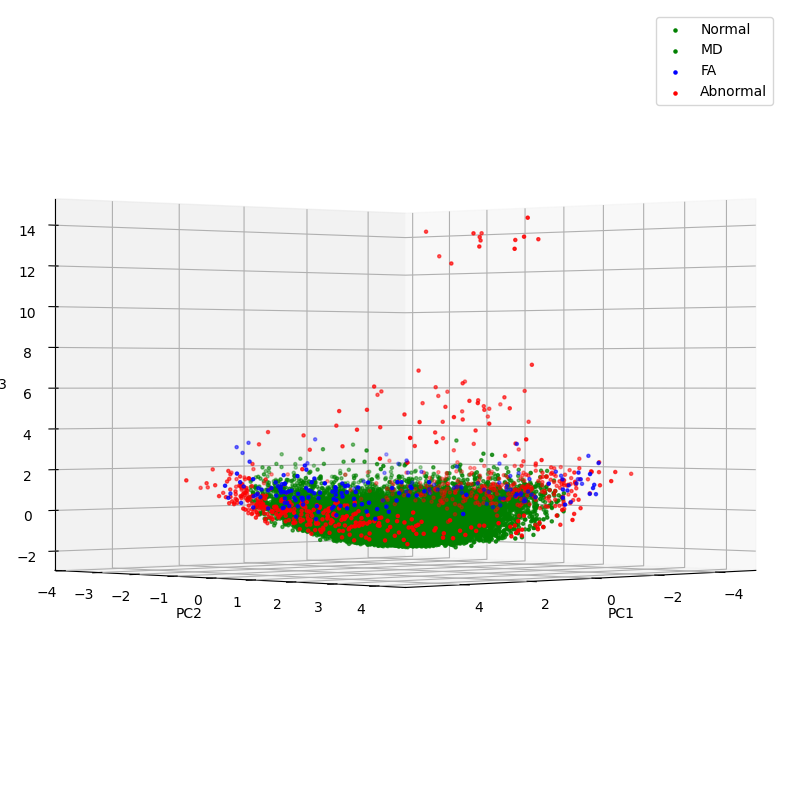

In [7]:
# 시각화
AD_type2color = {'Normal': 'green', 'MD': 'green', 'FA': 'blue', 'Abnormal': 'red'}
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
pc1 = ad_df['PC1']
pc2 = ad_df['PC2']
pc3 = ad_df['PC3']
type = ad_df['AD']
for t in AD_type2color:
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], c = AD_type2color[t], label = t, marker = '.')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
azimuth_angle = 45
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
ax.legend()
plt.show()

### Dicision Tree 기반 False Alarm Classification
#### 야전 침대 구매하기

False Alarm 데이터: 183개
True Alarm 데이터: 677개
합계: 860개


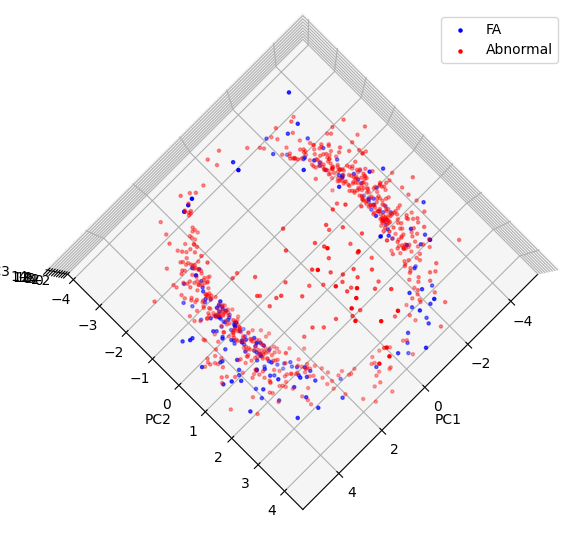

In [8]:
fac_df = ad_df[(ad_df['AD'] == 'Abnormal') | (ad_df['AD'] == 'FA')]
print('False Alarm 데이터: ' + str(len(ad_df[ad_df['AD'] == 'FA'])) + '개')
print('True Alarm 데이터: ' + str(len(ad_df[ad_df['AD'] == 'Abnormal'])) + '개')
print(f'합계: {len(fac_df)}개')
# fac_df

AD_type2color = {'FA': 'blue', 'Abnormal': 'red'}
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
pc1 = fac_df['PC1']
pc2 = fac_df['PC2']
pc3 = fac_df['PC3']
type = fac_df['AD']
for t in AD_type2color:
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], c = AD_type2color[t], label = t, marker = '.')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
azimuth_angle = 45
elevation_angle = 89
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
ax.legend()
plt.show()

              precision    recall  f1-score   support

    Abnormal       0.89      0.96      0.93       135
          FA       0.81      0.57      0.67        37

    accuracy                           0.88       172
   macro avg       0.85      0.77      0.80       172
weighted avg       0.87      0.88      0.87       172



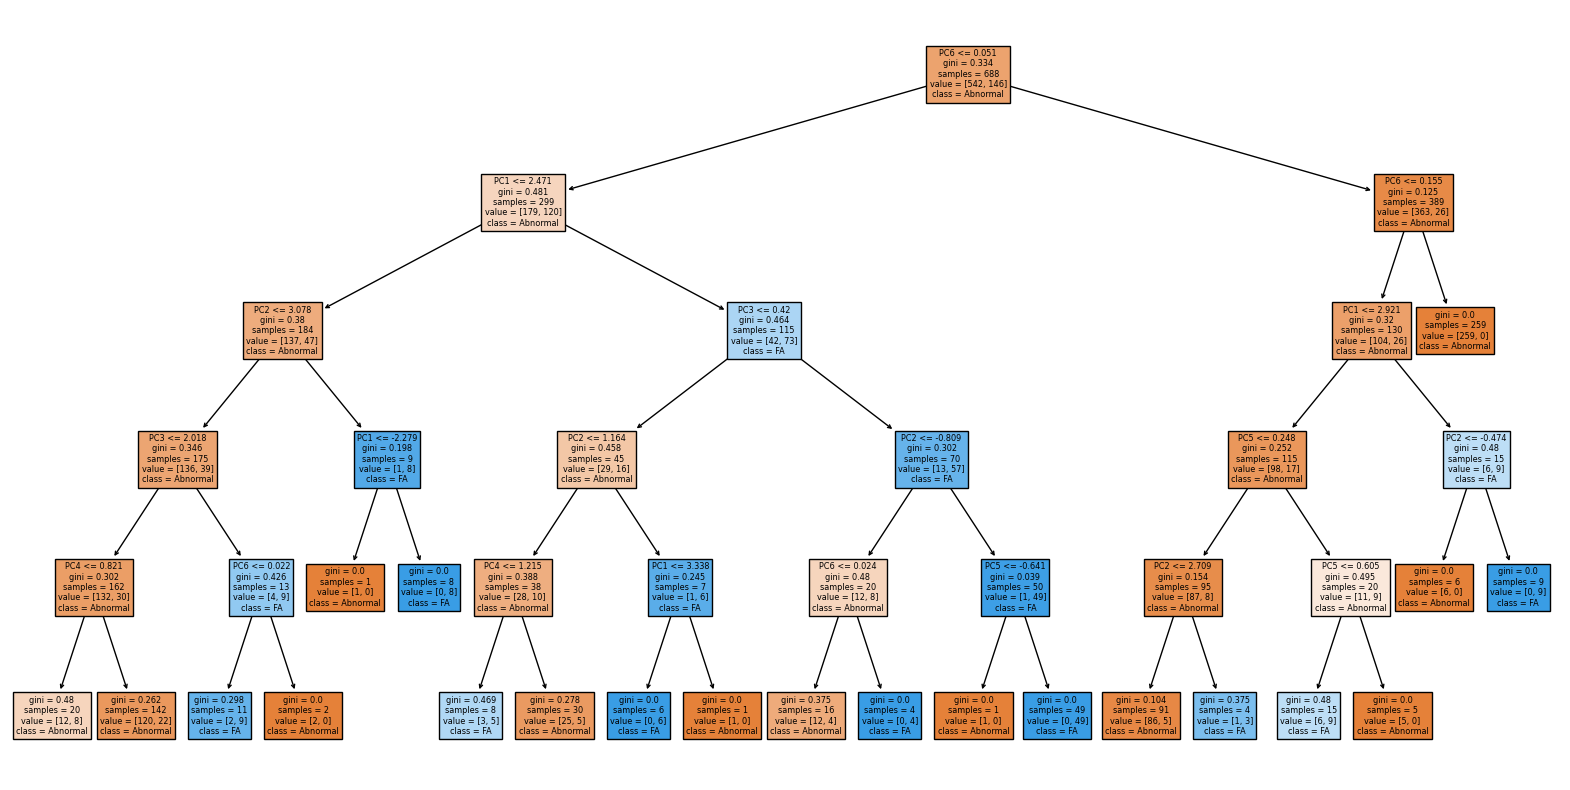

In [9]:
X = fac_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]  # 독립 변수
y = fac_df['AD']  # 종속 변수 (AD 값)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = DecisionTreeClassifier(max_depth = 5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# 분류 보고서 생성
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

# Dicision Tree 분류 기준 시각화
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_)
plt.show()

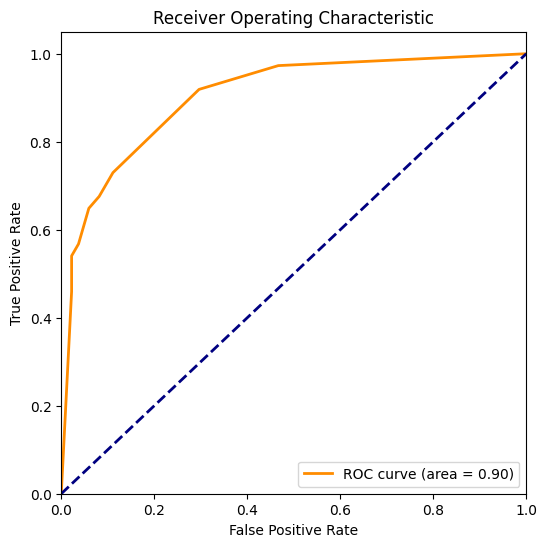

In [10]:
y_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1], pos_label='FA')
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

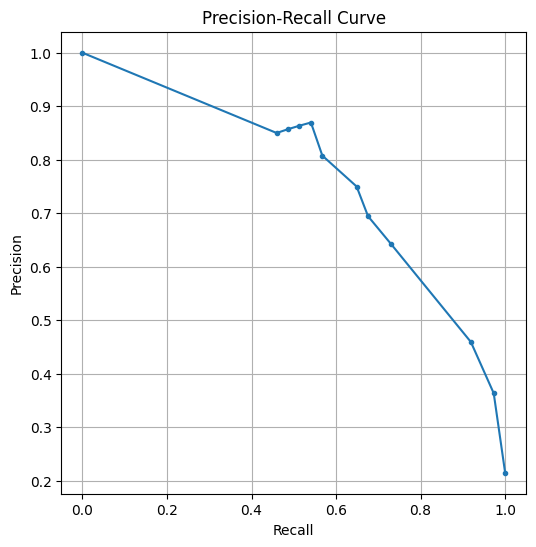

In [11]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1], pos_label='FA')

# Precision-Recall 커브 그리기
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [12]:
# Create a boolean mask for rows where y_pred is 'FA'
# Get the indices where y_pred is 'FA'
fa_indices = X_test.index[y_pred == 'FA']

# Use the fa_indices to filter fac_df
pred_as_fa = fac_df.loc[fa_indices]
print(f'Test Set 중 False Alarm으로 예측된 것: {len(pred_as_fa)}개')
pred_as_fa

Test Set 중 False Alarm으로 예측된 것: 27개


,PC1,PC2,PC3,PC4,PC5,PC6,Type,AD,Mahalanobis_Distance
372,3.918132,1.519429,0.787310,1.745552,-0.116280,0.004932,Normal,FA,5.380846
1316,0.666073,3.351263,0.962261,0.602275,0.253116,-0.018133,Normal,FA,3.755825
2890,2.749700,0.862243,1.029494,0.249913,0.625363,-0.085300,Normal,FA,3.723784
801,3.023402,0.419654,0.987499,0.560036,-0.233283,0.009563,Normal,FA,3.974290
4032,3.278318,-0.302871,-0.007936,1.748375,0.246794,0.073237,CoreSevered,Abnormal,4.308752
242,2.898373,-0.308010,0.597133,0.793835,-0.279144,0.018664,Normal,FA,3.773250
9589,-2.793295,1.859850,0.023977,1.942606,0.370118,0.097353,SideDamaged,Abnormal,4.217226
864,2.896972,-1.275389,1.121783,0.828709,-0.261577,0.029298,Normal,FA,4.060147
1080,3.193331,1.610829,0.513466,1.487398,-0.635202,-0.010838,Normal,FA,4.522215
2767,-2.006372,3.180014,1.308075,0.901329,0.311080,-0.092992,Normal,FA,4.389607


In [13]:
fa_indices = X_test.index[y_pred == 'FA']

# Use the fa_indices to drop rows from fac_df
fac_df.drop(fa_indices, inplace=True)

print(f'Data removed: {len(fa_indices)} pieces')
fac_df

Data removed: 26 pieces


C:\Users\99kit\AppData\Local\Temp\ipykernel_26600\640450313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fac_df.drop(fa_indices, inplace=True)


,PC1,PC2,PC3,PC4,PC5,PC6,Type,AD,Mahalanobis_Distance
61,2.477814,-1.766341,0.682384,1.146523,-0.347041,-0.041523,Normal,FA,3.772954
215,-0.728850,-3.102074,2.164970,0.781322,-0.077767,-0.008866,Normal,FA,3.821187
261,-0.657203,-2.833381,3.390435,0.249966,-0.296633,-0.068060,Normal,FA,4.037942
283,1.039521,-3.163696,3.242105,0.350370,0.455017,-0.012061,Normal,FA,4.369466
301,2.845981,0.168572,-0.294534,1.497515,0.091919,-0.056570,Normal,FA,3.737972
...,...,...,...,...,...,...,...,...,...
10626,-3.019596,-1.466325,0.241446,2.463623,0.150134,0.052237,SideDamaged,Abnormal,4.373588
10631,-2.267611,1.558581,2.276367,-0.086779,0.025608,-0.009117,SideDamaged,Abnormal,3.752536
10639,-2.727315,-1.637939,0.527803,1.707305,0.626919,0.016081,SideDamaged,Abnormal,4.030620
10648,-2.863526,0.125697,-0.418269,2.355145,0.499975,-0.071653,SideDamaged,Abnormal,3.891522


### Classification and Diagnosis of Timing Belt
#### Type(벨트의 결함 유형) 별 분류 성능 필요.
#### Random Forest를 이용해 변수 중요도 파악 결과, PC1과 PC6이 평균보다 높은 중요도를 보임. 원본의 변수가 주성분 결정에 미친 영향을 알아볼 수 있는 PCA Loading 사용.

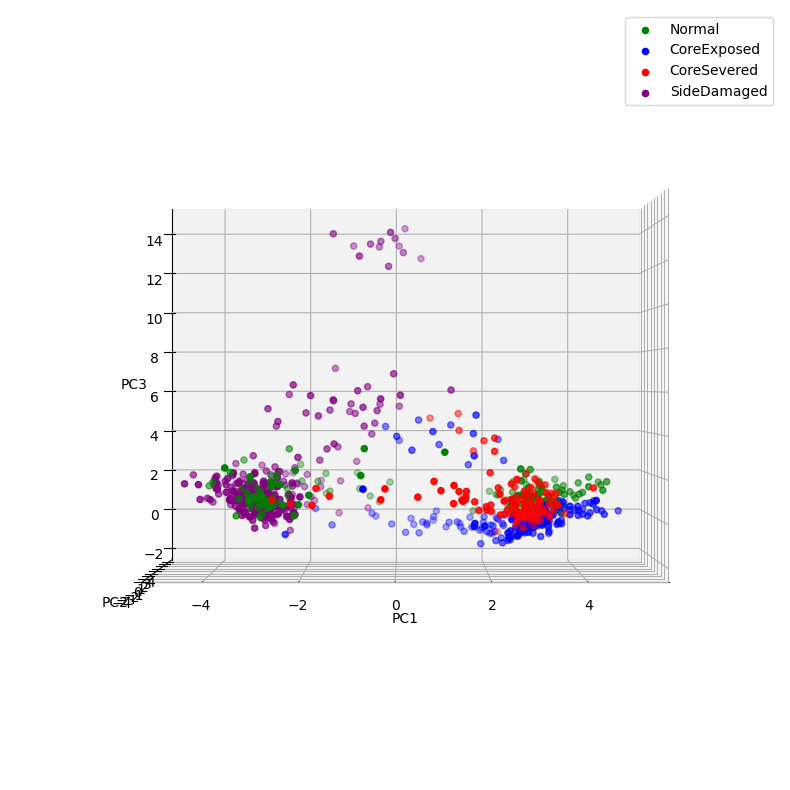

In [14]:
# 분류하고자 하는 데이터(fac_df)는 어떻게 생겼나?
type2cololr = {'Normal': 'green', 'CoreExposed': 'blue', 'CoreSevered': 'red', 'SideDamaged': 'purple'}
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
pc1 = fac_df['PC1']
pc2 = fac_df['PC2']
pc3 = fac_df['PC3']
type = fac_df['Type']
for t in type2cololr:
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], c = type2cololr[t], label = t, marker = 'o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
azimuth_angle = -90
elevation_angle = 0#89
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
ax.legend()
plt.show()

              precision    recall  f1-score   support

 CoreExposed       1.00      0.97      0.99        39
 CoreSevered       0.73      0.89      0.80        27
      Normal       0.89      0.53      0.67        32
 SideDamaged       0.88      0.99      0.93        69

    accuracy                           0.88       167
   macro avg       0.88      0.85      0.85       167
weighted avg       0.89      0.88      0.87       167



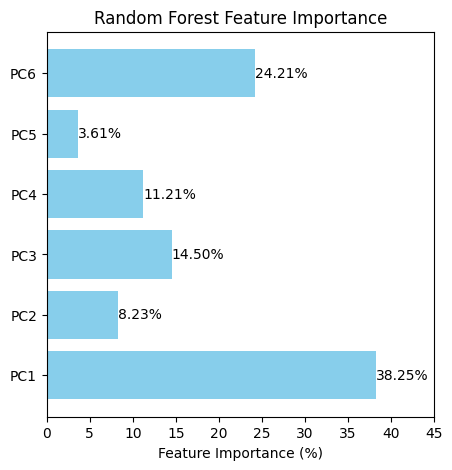

In [15]:
X = fac_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]
y = fac_df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
classification_rep = classification_report(y_test, y_pred) # Classification report
print(classification_rep)
# 변수 중요도
feature_importances = clf.feature_importances_ # 불순도(gini 지수)가 가장 빠르게 감소하는 특성을 가장 중요한 변수로 여김
feature_names = X.columns
total_importance = sum(feature_importances)
percentage_importances = [100 * (fi / total_importance) for fi in feature_importances]
plt.figure(figsize=(5, 5))
plt.barh(feature_names, percentage_importances, color='skyblue')
plt.xlabel('Feature Importance (%)')
# plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.xlim(0, 45)  # x 축의 범위를 0에서 100으로 설정

# 바 위에 퍼센티지 표시
for index, value in enumerate(percentage_importances):
    plt.text(value, index, f'{value:.2f}%', va='center')

plt.show()

In [16]:
# PCA Loading # PC1과 PC6이 가장 많이 설명하는 변수는 무엇인가?
loadings = pca.components_
pc1_loadings = loadings[0] # PC1에 대한 원본 변수의 가중치
pc6_loadings = loadings[5] # PC6
pc1_variable_loadings = dict(zip(independent_variables, pc1_loadings)) # 가중치를 원본 변수 이름과 연결하여 해당 주성분에 가장 많이 기여하는 원본 변수 이해
pc6_variable_loadings = dict(zip(independent_variables, pc6_loadings))
# 변수 로딩 값을 크기(절대값)에 따라 정렬하여 PC1에 대한 가장 중요한 원본 변수를 확인할 수 있습니다.
sorted_pc1_loadings = sorted(pc1_variable_loadings.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_pc6_loadings = sorted(pc6_variable_loadings.items(), key=lambda x: abs(x[1]), reverse=True)
print("PC1에 대한 로딩:")
for variable, loading in sorted_pc1_loadings:
    print(f"{variable}: {loading:.4f}")
print()
print("PC6에 대한 로딩:")
for variable, loading in sorted_pc6_loadings:
    print(f"{variable}: {loading:.4f}")

PC1에 대한 로딩:
Kurt_Int_Sound: -0.7059
Var_Int_Sound: 0.6614
Skew_Int_Sound: -0.2497
RMS: 0.0428
Mean_Int_Sound: 0.0083
Tension: 0.0060

PC6에 대한 로딩:
Tension: 0.9999
Var_Int_Sound: -0.0115
RMS: 0.0094
Mean_Int_Sound: 0.0040
Kurt_Int_Sound: -0.0016
Skew_Int_Sound: -0.0003


              precision    recall  f1-score   support

 CoreExposed       0.97      1.00      0.99        39
 CoreSevered       0.68      0.93      0.78        27
      Normal       0.82      0.44      0.57        32
 SideDamaged       0.89      0.94      0.92        69

    accuracy                           0.86       167
   macro avg       0.84      0.83      0.81       167
weighted avg       0.86      0.86      0.84       167



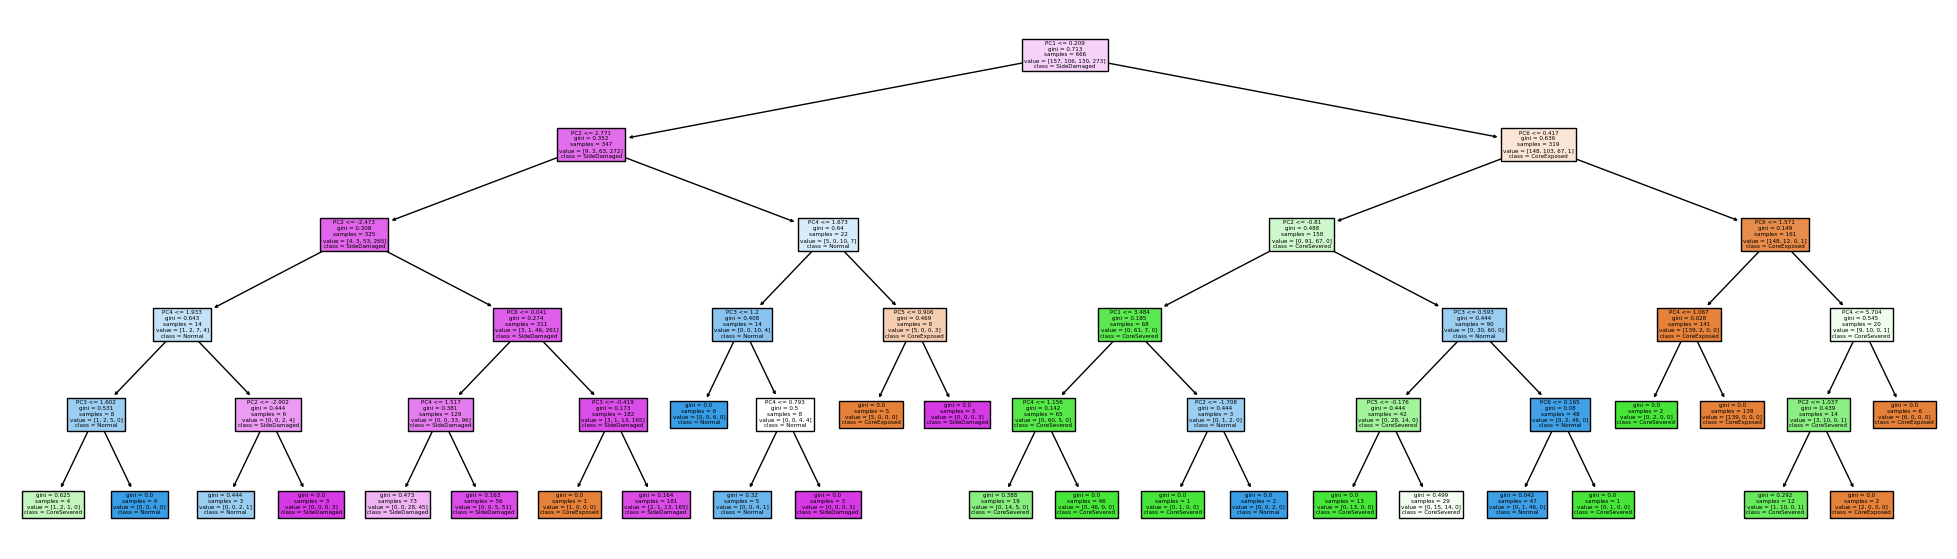

In [17]:
# 분류 기준 시각화를 위한 Dicision Tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = DecisionTreeClassifier(max_depth = 5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# 분류 보고서 생성
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)
# 시각화
plt.figure(figsize=(25, 7))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_)
plt.show()